In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
import pandas as pd

from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
import kagglehub

path = kagglehub.dataset_download("manideep1108/tusimple")

print("Path to dataset files:", path)

100%|██████████| 21.6G/21.6G [17:06<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/manideep1108/tusimple/versions/5


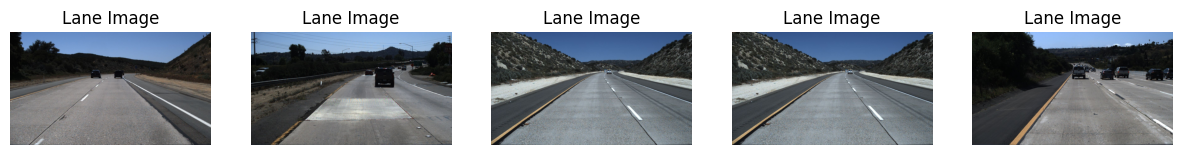

In [107]:
# Setting annotations path
dataset_path = os.path.join(path, 'TUSimple/train_set')
json_file = os.path.join(dataset_path, 'label_data_0531.json')

with open(json_file, 'r') as f:
        annotations = [json.loads(line) for line in f]

# Showing random images from the dataset
def show_random_images(annotations, dataset_path, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        sample = random.choice(annotations)
        img_path = os.path.join(dataset_path, sample['raw_file'])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image wasn`t found: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title("Lane Image")
        plt.axis('off')
    plt.show()

show_random_images(annotations, dataset_path)

In [108]:
# Prepocessing images by converting to grayscale and detecting edges

def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0) # Appling Gaussian blur to reduce noise
    edges = cv2.Canny(blurred, 40, 130)
    return edges

# Function to focus on the region of interest

def region_of_interest(img):
    height, width = img.shape
    mask = np.zeros_like(img)

    polygon = np.array([[
        (0, height),
        (width, height),
        (width // 2, height // 2)
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [109]:
#lane detection pipeline
def detect_lanes(img):
    edges = preprocess_image(img)
    roi = region_of_interest(edges)

    # Lane detections with Hough
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=250, minLineLength=50, maxLineGap=50)

    # Drawing the detected lines on a blank image

    line_img = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 0), 5)

    return cv2.addWeighted(img, 0.8, line_img, 1, 1)


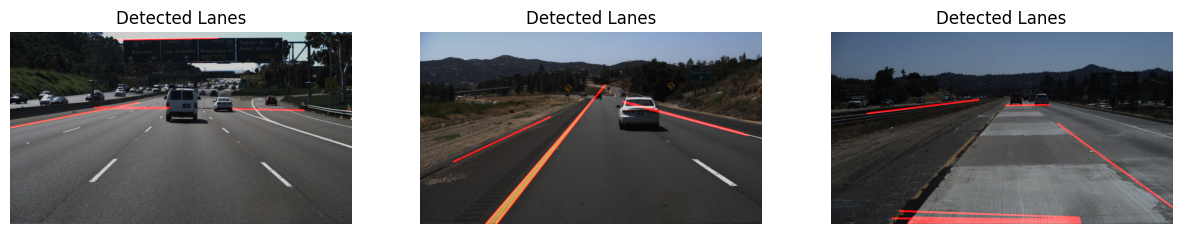

In [111]:
# Visualizing lane detection results

def visualize_results(annotations, dataset_path, num_images=3):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        sample = random.choice(annotations)
        img_path = os.path.join(dataset_path, sample['raw_file'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = detect_lanes(img)

        plt.subplot(1, num_images, i+1)
        plt.imshow(result)
        plt.title("Detected Lanes")
        plt.axis('off')
    plt.show()

# Showing results
visualize_results(annotations, dataset_path)

In [112]:
# This function helps visualizing the lane markings
def create_lane_mask(annotation, img_size):
    mask = np.zeros(img_size, dtype=np.uint8)
    lanes = annotation['lanes']
    y_samples = annotation['h_samples']
    for lane in lanes:
        points = [(x, y) for x, y in zip(lane, y_samples) if x != -2]
        for i in range(len(points) - 1):
            cv2.line(mask, points[i], points[i+1], 255, thickness=5)
    return mask

In [113]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u2 = layers.UpSampling2D((2, 2))(b)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Concatenate()([u2, c2])

    u1 = layers.UpSampling2D((2, 2))(u2)
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Concatenate()([u1, c1])

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u1)

    return Model(inputs, outputs)

model = unet_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 256, 256, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 128, 128, 32)   │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 64, 64, 64)     │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 128, 128, 128)  │              0 │ conv2d_14[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 128, 128, 64)   │         73,792 │ up_sampling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 128, 128, 128)  │              0 │ conv2d_15[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 256, 256, 128)  │              0 │ concatenate_2[0][0]    │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 256, 256, 32)   │         36,896 │ up_sampling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 256, 256, 64)   │              0 │ conv2d_16[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 256, 256, 1)    │             65 │ concatenate_3[0][0]    │
└──────────────────────

 Total params: 397,761 (1.52 MB)

 Trainable params: 397,761 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
# Preprocess data for training

def preprocess_data(image_path, mask):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0  # Normalize to range [0, 1]
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    mask = (mask > 0).astype(np.uint8)  # Ensure binary mask
    return img, mask


In [115]:
#Defining loss function
def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1)


Epoch 1/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 357s 8s/step - accuracy: 0.0165 - loss: 0.9689
Epoch 2/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 369s 8s/step - accuracy: 0.6233 - loss: 0.9464
Epoch 3/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 373s 7s/step - accuracy: 0.9756 - loss: 0.7873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


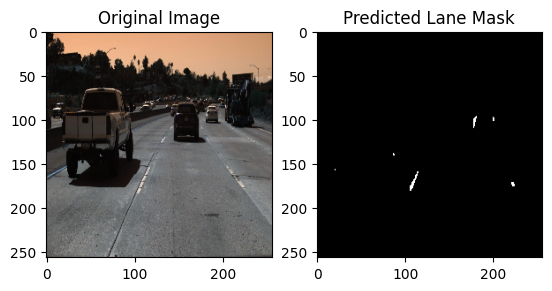

In [116]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=['accuracy'])
# Preprocessing Data
train_images, train_masks = [], []
for annotation in annotations[:500]:  # Train on more data
    img_path = os.path.join(dataset_path, annotation['raw_file'])
    mask = create_lane_mask(annotation, (720, 1280))
    img, mask = preprocess_data(img_path, mask)
    train_images.append(img)
    train_masks.append(mask)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Training =
model.fit(train_images, train_masks, batch_size=8, epochs=3 )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


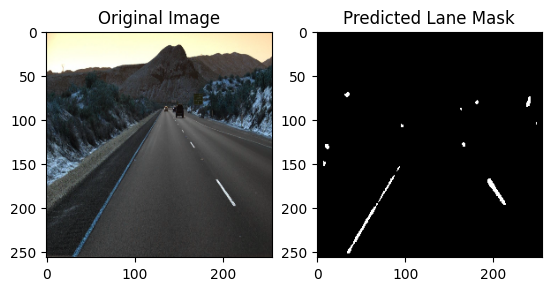

In [121]:
# Prediction
sample = random.choice(annotations)
img_path = os.path.join(dataset_path, sample['raw_file'])
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (256, 256)) / 255.0

pred_mask = model.predict(np.expand_dims(img_resized, axis=0))[0]
pred_mask = (pred_mask[:, :, 0] > 0.5).astype(np.uint8)

# Visualizing
plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Lane Mask")
plt.show()
